In [52]:
##############################
#Part 1: LCC Change Detection#
#Maintainer: Christopher Chan#
#Version: 0.1.2              #
#Date: 2025-02-14            #
##############################

import os
import json

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

from pathlib import Path
from PIL import Image
from osgeo import gdal
from rasterio.mask import mask
from rasterio.enums import Resampling

%matplotlib inline

# path setup
BASE_PATH = Path(os.getcwd())
data_raw = (BASE_PATH/'../data/01_raw').resolve()
data_intermediate = (BASE_PATH/'../data/02_intermediate').resolve()
data_model_output = (BASE_PATH/'../data/07_model_output').resolve()

In [53]:
# First let's explore and visualise the raster and vector data, look for any issues

lc_2020 = gdal.Open(f'{data_raw}/raster/spain_2020.tif')
lc_2020_meta = lc_2020.GetGeoTransform()
print(gdal.Info(lc_2020))

lc_2021 = gdal.Open(f'{data_raw}/raster/spain_2021.tif')
lc_2021_meta = lc_2021.GetGeoTransform()
print(gdal.Info(lc_2021))

lc_2022 = gdal.Open(f'{data_raw}/raster/spain_2022.tif')
lc_2022_meta = lc_2022.GetGeoTransform()
print(gdal.Info(lc_2022))

assert lc_2022.GetProjection() == lc_2021.GetProjection() == lc_2020.GetProjection()

Driver: GTiff/GeoTIFF
Files: /Users/christopherchan/Proj/natcap-interview/data/01_raw/raster/spain_2020.tif
Size is 113214, 181269
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
          

Woop, it seems that the first image have a ```Pixel Size = (10.027727092806259,-10.027727092806259)```, this might cause further issues. Need to resample the first image to match the other two. **Resampling will be done on the first image that is cropped to the AOI.**

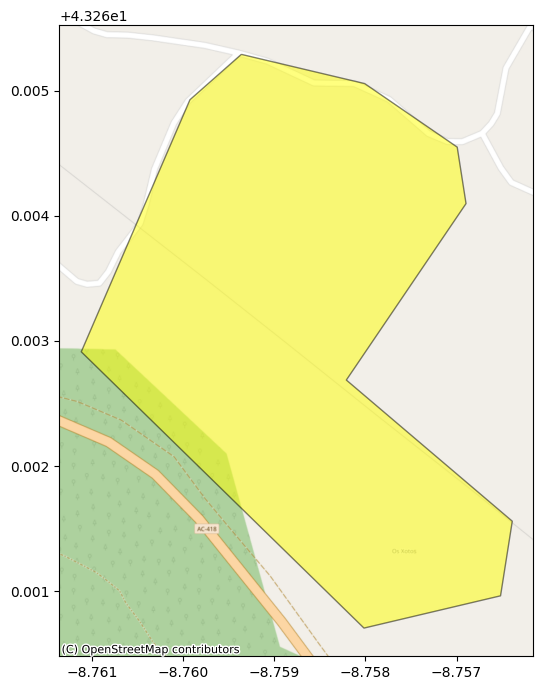

In [54]:
# Clip to AOI
with open(f'{data_raw}/vector/Part_1/id_1.geojson', 'r') as gdf:
    aoi = gpd.read_file(gdf)

fig, ax = plt.subplots(figsize=(7, 7))
ax = aoi.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.5)
cx.add_basemap(ax=ax, crs=aoi.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()
plt.show()

if aoi.crs != 'EPSG:32630':
    aoi_32630 = aoi.to_crs(epsg=32630)
    aoi_32630.to_file(f'{data_raw}/vector/Part_1/id_1_32630.geojson', driver='GeoJSON')


/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_1709/1732886533.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


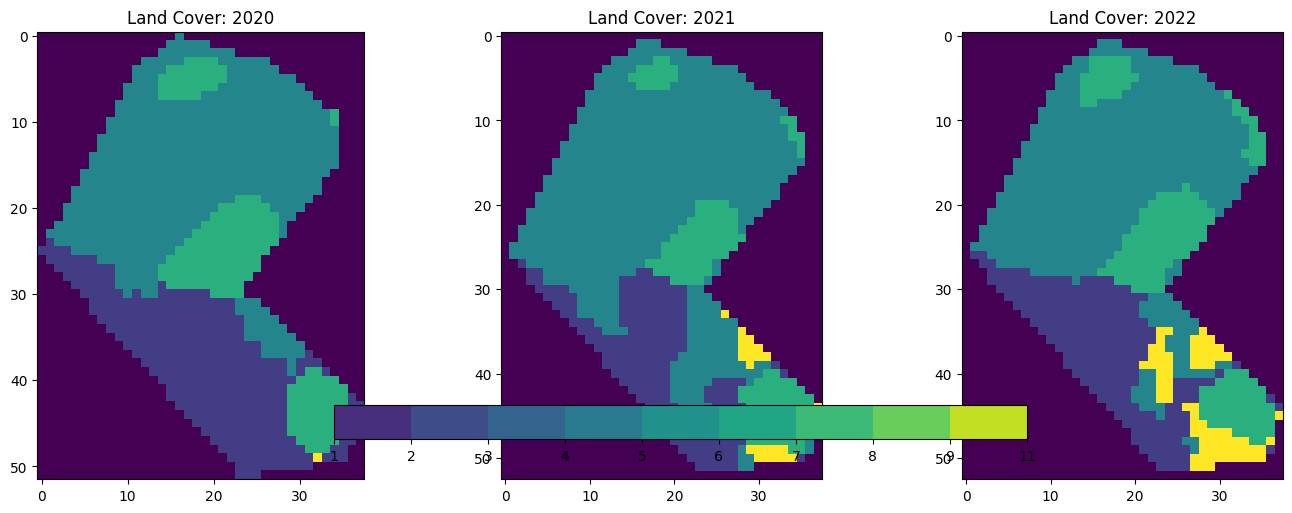

In [55]:
# Clip raster and apply cloud mask
raster_ls = [lc_2020.GetDescription(), lc_2021.GetDescription(), lc_2022.GetDescription()]

clip_rasterls = []

for raster in raster_ls:
    year = raster.split('_')[2].split('.')[0]

    with rio.open(raster, "r") as src:
        clipped_image, clipped_transform = mask(src, aoi_32630.geometry, crop=True)
        # Cloud mask set 10 to G
        clipped_image = np.where((clipped_image == 0) | (clipped_image == 10), 0, clipped_image).astype(np.int8)

        profile = src.profile.copy()
        profile.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })

    with rio.open(f'{data_intermediate}/raster/Part_1/spain_{year}_clipped.tif', "w", **profile) as dst:
        dst.write(clipped_image)

    # Append the clipped array (which has shape: [bands, height, width])
    clip_rasterls.append(clipped_image)

# Quick plot

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, img in enumerate(clip_rasterls):
    im = ax[idx].imshow(img[0])
    ax[idx].set_title(f'Land Cover: {raster_ls[idx].split("_")[2].split(".")[0]}')

arr = np.arange(1, 12)
arr_filtered = arr[arr != 10]

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.09, ticks=arr_filtered,
                    boundaries=arr_filtered)

plt.tight_layout()
plt.show()


Resampling on cropped image

In [56]:
with rio.open(f'{data_intermediate}/raster/Part_1/spain_2020_clipped.tif', 'r') as src:
    print(src.res)
    resamp_2020 = src.read(
        out_shape=(
            src.count,
            int(src.height * src.res[0]/ 10),
            int(src.width * src.res[1]/ 10)
        ),
        resampling=Resampling.nearest
    )
    transform = src.transform * src.transform.scale(
        (src.width / resamp_2020.shape[-1]),
        (src.height / resamp_2020.shape[-2])
    )
    # Write to disk
    with rio.open(f'{data_intermediate}/raster/Part_1/ResampSpain_2020_clipped.tif', "w",
        driver='GTiff',
        count=src.count,
        dtype=src.dtypes[0],
        crs=src.crs,
        transform=transform,
        width=resamp_2020.shape[-1],
        height=resamp_2020.shape[-2]
    ) as dst:
        dst.write(resamp_2020)

(10.02772709280626, 10.02772709280626)


In [57]:
# Check the resampled image
lc_2020 = gdal.Open(f'{data_intermediate}/raster/Part_1/ResampSpain_2020_clipped.tif')
lc_2020_meta = lc_2020.GetGeoTransform()
print(gdal.Info(lc_2020))

Driver: GTiff/GeoTIFF
Files: /Users/christopherchan/Proj/natcap-interview/data/02_intermediate/raster/Part_1/ResampSpain_2020_clipped.tif
Size is 38, 52
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easti

### Nearest neighbour resampling does not seem to be working properly, I tried to resample to different resolution which works but for tiny pixel difference, does not seem to be working.

Used padding to fix dimension issue since the bottom since the bottom matrix row is 0 / "NaN" anyway.

In [58]:
with rio.open(f'{data_intermediate}/raster/Part_1/spain_2020_clipped.tif', 'r') as src:
    lc_2020 = src.read()

In [59]:
lc_2020_pad = np.pad(
    lc_2020,
    pad_width=(
        (0, 0),
        (0, 1),
        (0, 0),
    ),
    mode="constant",
    constant_values=0,
)

print(lc_2020_pad.shape)

(1, 53, 38)


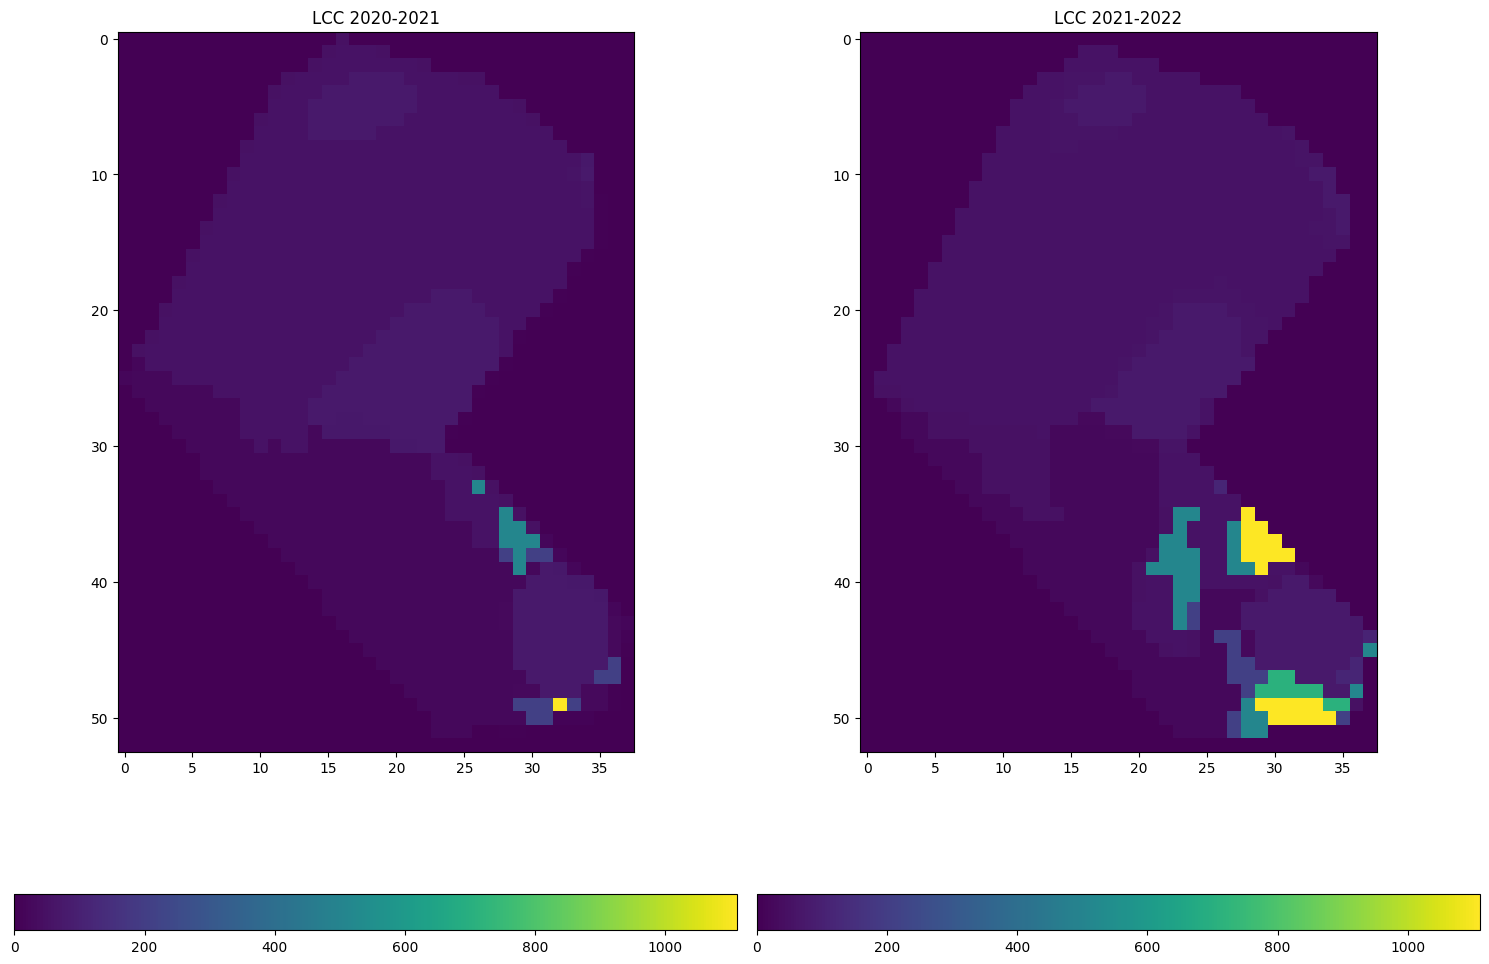

In [60]:
# Change Detection
# Replace lc_2020 with lc_2020_pad
clip_rasterls[0] = lc_2020_pad

# Cast np.ndararay as string
str_rasterls = [raster.astype(str) for raster in clip_rasterls]

LCC2020_2021 = np.char.add(str_rasterls[0], str_rasterls[1]).astype(np.float16)
LCC2021_2022 = np.char.add(str_rasterls[1], str_rasterls[2]).astype(np.float16)

# string version

def LCC_str_ndarray(LC1:np.ndarray, LC2:np.ndarray) -> np.ndarray:
    temp_array = np.char.add(LC1, ":")
    return np.char.add(temp_array, LC2)

LCC2020_2021_str = LCC_str_ndarray(str_rasterls[0], str_rasterls[1])
LCC2021_2022_str = LCC_str_ndarray(str_rasterls[1], str_rasterls[2])
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

LCCPlot_2020_2021 = ax[0].imshow(LCC2020_2021[0])
ax[0].set_title('LCC 2020-2021')
LCCPlot_2021_2022 = ax[1].imshow(LCC2021_2022[0])
ax[1].set_title('LCC 2021-2022')

cbar = fig.colorbar(LCCPlot_2020_2021, ax=ax[0], orientation='horizontal', fraction=0.09)
cbar = fig.colorbar(LCCPlot_2021_2022, ax=ax[1], orientation='horizontal', fraction=0.09)
plt.tight_layout()
plt.show()


## Final output

In [84]:
# Collect all the Land Cover and LCC change into a dataframe

result_df = pd.DataFrame({
    'Land Cover 2020': pd.Series(clip_rasterls[0].flatten()).value_counts(),
    'Land Cover 2021': pd.Series(clip_rasterls[1].flatten()).value_counts(),
    'Land Cover 2022': pd.Series(clip_rasterls[2].flatten()).value_counts(),
    #'LCC 2020-2021': pd.Series(LCC2020_2021_str.flatten()).value_counts(),
    #'LCC 2021-2022': pd.Series(LCC2021_2022_str.flatten()).value_counts()
    })

LCC2020_2021_df = pd.Series(LCC2020_2021_str.flatten()).value_counts().reset_index().rename(columns={'index': 'LCC', 'count': 'LCC 2020-2021'})
LCC2021_2022_df = pd.Series(LCC2021_2022_str.flatten()).value_counts().reset_index().rename(columns={'index': 'LCC', 'count': 'LCC 2021-2022'})

result_df = result_df.reset_index().rename(columns={'index': 'LCC'})
result_df["LCC"] = result_df["LCC"].astype(int).astype(str)

result_df_LCC = pd.merge(result_df, LCC2020_2021_df, on='LCC', how='outer')
result_df_LCC = pd.merge(result_df_LCC, LCC2021_2022_df, on='LCC', how='outer')

def map_cover_class(value, class_dict):
    # Check if the value is in the dictionary
    if value in class_dict:
        return class_dict[value]
    # Check for combined values like '0:0' or 'NaN:NaN'
    elif ':' in value:
        parts = value.split(':')
        # Map each part and join them with a separator
        return ':'.join(class_dict.get(part, 'Unknown') for part in parts)
    else:
        return 'Unknown'

# Load the class dictionary
with open(f'{data_raw}/vector/LC_classes.json', encoding='utf-8-sig') as js:
    class_json = json.load(js)
    class_dict = class_json['classes']

# Apply the mapping function to the 'LCC' column
result_df['cover_class'] = result_df['LCC'].apply(lambda x: map_cover_class(x, class_dict))
result_df_LCC['cover_class'] = result_df_LCC['LCC'].apply(lambda x: map_cover_class(x, class_dict))

result_df_LCC.to_csv(f'{data_model_output}/result_df.csv', index=False)

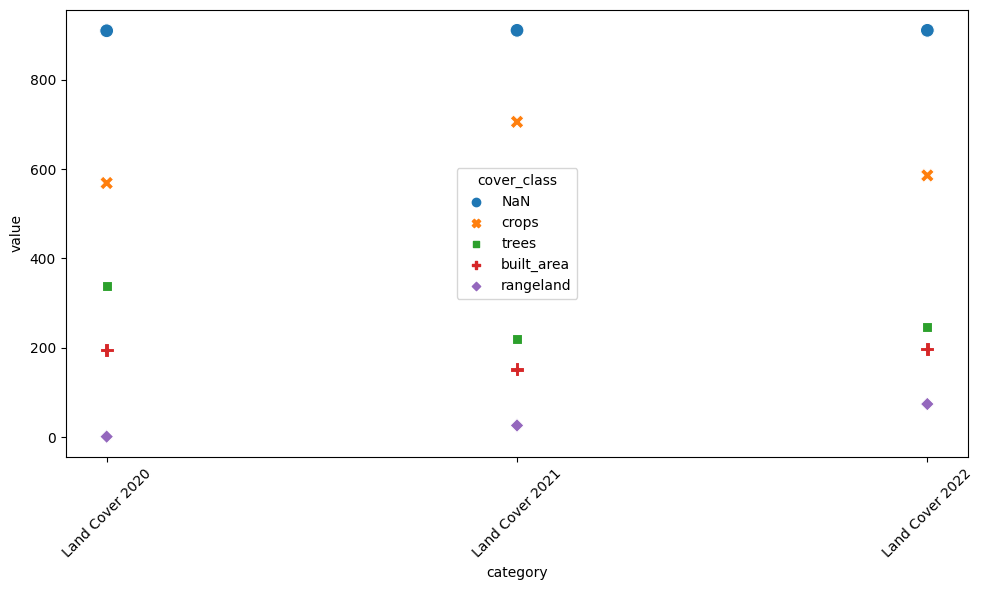

In [85]:
# Plotting
cols_to_plot = ['Land Cover 2020', 'Land Cover 2021', 'Land Cover 2022']

# Reshape the dataframe from wide to long format
melted_df = pd.melt(result_df, id_vars=['LCC', 'cover_class'], 
                    value_vars=cols_to_plot, 
                    var_name='category', 
                    value_name='value')

# Convert values to numeric, if they are not already.
melted_df['value'] = pd.to_numeric(melted_df['value'], errors='coerce')

# Optionally, drop rows where the value is missing
melted_df = melted_df.dropna(subset=['value'])

# Create the scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=melted_df, x='category', y='value', hue='cover_class', style='cover_class', s=100)

# Optionally rotate the x labels for clarity
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
result_df

,LCC,Land Cover 2020,Land Cover 2021,Land Cover 2022,cover_class
0,0,910,911,911,NaN
1,5,569,706,586,crops
2,2,339,219,246,trees
3,7,195,152,197,built_area
4,11,1,26,74,rangeland


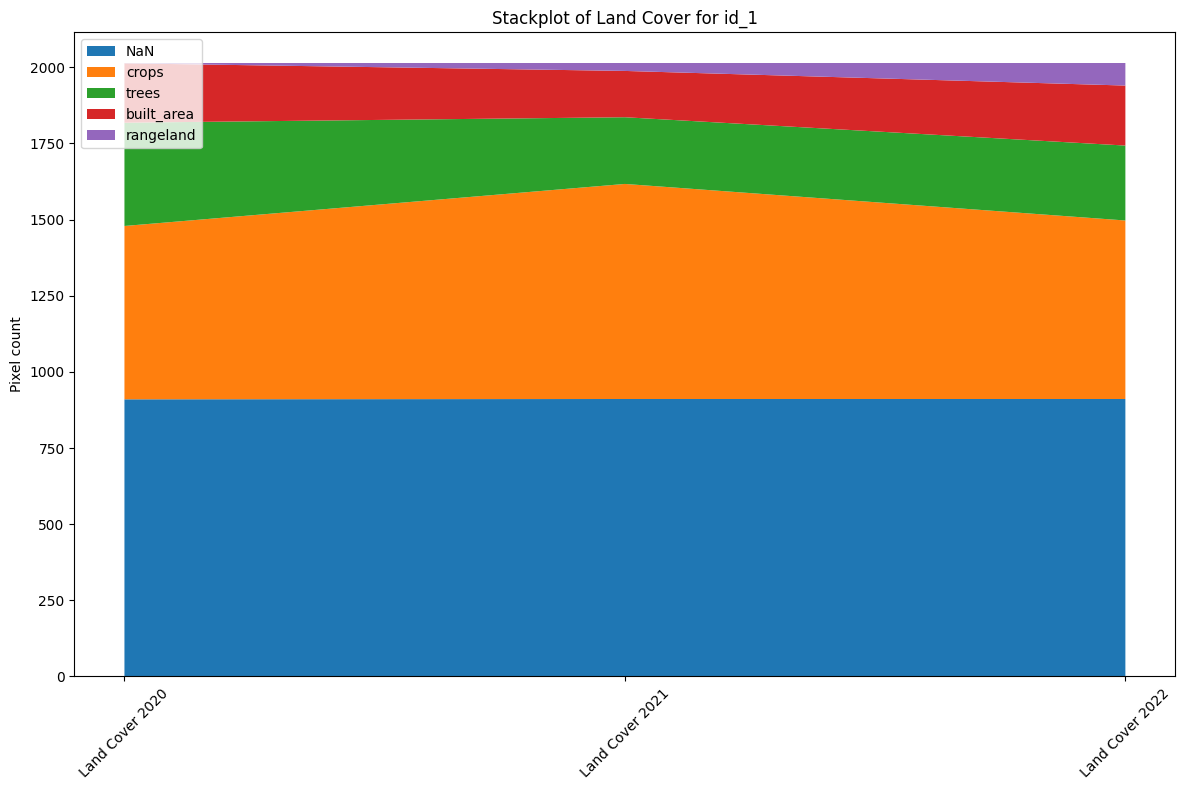

In [90]:
stack_data = {}
for cover_class in result_df['cover_class'].unique():
    # Extract values for each cover_class and ensure NaNs are replaced with 0
    class_data = result_df[result_df['cover_class'] == cover_class][cols_to_plot].fillna(0).sum(axis=0)
    stack_data[cover_class] = class_data.values

# Prepare x-axis labels
x_labels = cols_to_plot

# Create the stackplot
plt.figure(figsize=(12, 8))
plt.stackplot(x_labels, *stack_data.values(), labels=stack_data.keys())
plt.legend(loc='upper left')
plt.title('Stackplot of Land Cover for id_1')
plt.ylabel('Pixel count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()